In [82]:
import collections
import os
import json
import logging

import pandas as pd
import numpy as np
import scipy
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sqlalchemy import create_engine

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.alphabet import ALPHABET_DNA
from rna_learn.load_sequences import (
    load_growth_temperatures, 
    compute_inverse_effective_sample,
    assign_weight_to_batch_values,
    SpeciesSequence,
)
from rna_learn.transform import sequence_embedding, normalize, denormalize
from rna_learn.model import conv1d_densenet_regression_model, compile_regression_model, DenormalizedMAE

In [2]:
sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()
logging.basicConfig(level=logging.INFO, format="%(asctime)s (%(levelname)s) %(message)s")

In [3]:
db_path = os.path.join(os.getcwd(), 'data/condensed_traits/db/seq.db')
engine = create_engine(f'sqlite+pysqlite:///{db_path}')

In [4]:
run_id = 'run_yb64o'
model_path = os.path.join(os.getcwd(), f'saved_models/{run_id}/model.h5')
metadata_path = os.path.join(os.getcwd(), f'saved_models/{run_id}/metadata.json')
validation_csv = os.path.join(os.getcwd(), f'saved_models/{run_id}/validation.csv')

In [5]:
with open(metadata_path) as f:
    metadata = json.load(f)
    
metadata

{'run_id': 'run_yb64o',
 'alphabet': ['A', 'C', 'G', 'T'],
 'learning_rate': 0.0005,
 'batch_size': 64,
 'encoding_size': 20,
 'decoder_n_hidden': 100,
 'growth_rate': 15,
 'n_layers': 10,
 'kernel_sizes': [3, 5, 5, 5, 5, 5, 5, 5, 5, 5],
 'strides': None,
 'dilation_rates': None,
 'l2_reg': 1e-05,
 'dropout': 0.5,
 'n_epochs': 10,
 'max_sequence_length': 5000,
 'seed': 28,
 'val_loss': 1.5334341526031494}

In [6]:
model = conv1d_densenet_regression_model(
    alphabet_size=len(metadata['alphabet']), 
    growth_rate=metadata['growth_rate'],
    n_layers=metadata['n_layers'],
    kernel_sizes=metadata['kernel_sizes'],
    dilation_rates=metadata['dilation_rates'],
    l2_reg=metadata['l2_reg'],
    dropout=metadata['dropout'],
)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, None, 15)     195         sequence[0][0]                   
__________________________________________________________________________________________________
concat_1 (Concatenate)          (None, None, 19)     0           sequence[0][0]                   
                                                                 conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, None, 15)     1440        concat_1[0][0]        

## Load sequences from a single specie

In [7]:
query = """
select t.species, s.sequence, s.length, t.growth_tmp
from sequences as s
inner join species_traits as t
on t.species_taxid = s.species_taxid
where s.species_taxid = ?
"""
species_taxid = 145261
species_df = pd.read_sql(query, engine, params=(species_taxid,))
len(species_df)

2649

In [8]:
species = species_df['species'].iloc[0]
actual_tmp = species_df['growth_tmp'].iloc[0]
species, actual_tmp

('Methanothermobacter wolfeii', 60.0)

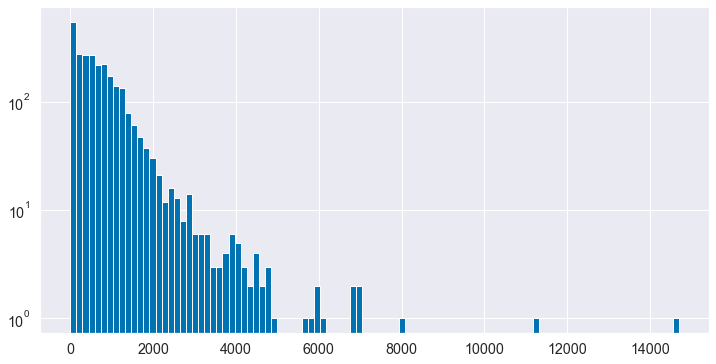

In [9]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist(species_df['length'], bins=100, log=True);

In [10]:
actual_tmp = species_df['growth_tmp'].iloc[0]
actual_tmp

60.0

In [11]:
temperatures, mean, std = load_growth_temperatures(engine)

In [12]:
max_sequence_length = metadata.get('max_sequence_length', 5000)
species_seq = SpeciesSequence(
    engine, 
    species_taxid=species_taxid,
    batch_size=64, 
    temperatures=temperatures,
    mean=mean,
    std=std,
    alphabet=ALPHABET_DNA, 
    max_sequence_length=max_sequence_length,
    random_seed=metadata['seed'],
)

In [13]:
compile_regression_model(
    model, 
    learning_rate=1e-4,
)
model.load_weights(model_path)

In [14]:
temperature_range = np.arange(-35, 145, 0.5)
temperature_range_norm = normalize(temperature_range, mean, std)

In [15]:
%%time
cursor = 0
n_sequences = len(species_seq.rowids)
predictions = np.zeros((n_sequences, 1))
log_probabilities = np.zeros((n_sequences, len(temperature_range)))
means = []
for i in range(len(species_seq)):
    if (i + 1) % 10 == 0:
        print(f'{i+1} / {len(species_seq)}')
    
    x_batch, _, _ = species_seq[i]
    
    a = cursor
    b = cursor + len(x_batch)
    
    dist = model(x_batch)
    y_pred_norm = dist.mean().numpy()
    y_pred = denormalize(y_pred_norm, mean, std)
    predictions[a:b] = y_pred
    
    for j, t in enumerate(temperature_range_norm):
        log_probs = dist.log_prob(t).numpy()
        log_probabilities[a:b, j] = log_probs
        
    for log_prob in log_probabilities[a:b]:
        probs_un = np.exp(scipy.special.logsumexp([log_prob], axis=0))
        probs_ = probs_un / np.sum(probs_un)
        mean_ = np.average(temperature_range, weights=probs_)
        means.append(mean_)
        
    cursor += len(x_batch)

10 / 42
20 / 42
30 / 42
40 / 42
CPU times: user 27.8 s, sys: 14.5 s, total: 42.3 s
Wall time: 20.5 s


In [16]:
probs_u = np.exp(scipy.special.logsumexp(log_probabilities, axis=0))
probs = probs_u / np.sum(probs_u)

In [17]:
mode = temperature_range[np.argmax(probs)]
mean = np.average(temperature_range, weights=probs)

In [18]:
actual_tmp, mean, mode

(60.0, 55.9266273301429, 56.0)

In [19]:
variance = np.average(
    [(t - mean)**2 for t in temperature_range], 
    weights=probs,
)
std = np.sqrt(variance)
std

23.248313321525128

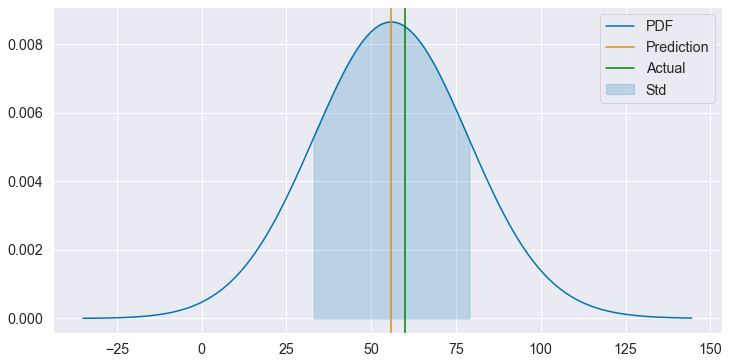

In [20]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(temperature_range, probs, label='PDF');
ax.axvline(mean, color=palette[1], label='Prediction');
ax.axvline(actual_tmp, color='green', label='Actual');

x_std_ix = [i for i, t in enumerate(temperature_range) if t >= mean - std and t <= mean + std]
ax.fill_between(temperature_range[x_std_ix], probs[x_std_ix], color=palette[0], alpha=0.2, label='Std');
ax.legend();

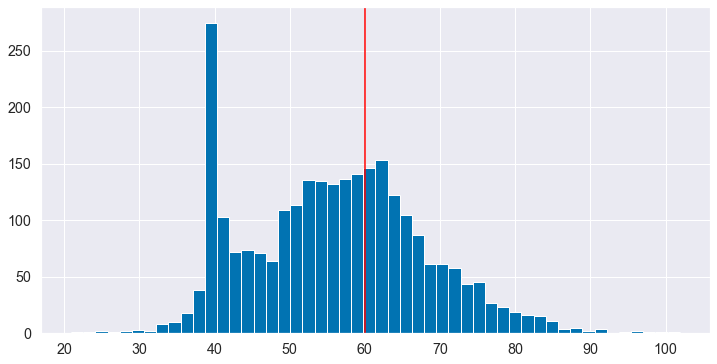

In [21]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist(means, bins=50);
ax.axvline(actual_tmp, color='red');

## Validation on test set

In [22]:
val_df = pd.read_csv(validation_csv).set_index('species_taxid')
val_df.head(10)

,growth_tmp_actual,growth_tmp_prediction,growth_tmp_std
species_taxid,,,
7,30.00,36.67,15.47
14,74.15,62.08,24.86
24,27.00,27.02,19.60
35,27.00,40.85,15.06
63,30.00,35.35,16.61
114,30.00,39.10,15.19
128,42.80,40.27,16.59
134,30.00,34.78,16.27
154,65.00,60.68,20.76


In [23]:
val_df['growth_tmp_std'].mean()

18.493841059602648

In [24]:
abs_diff = np.abs(val_df['growth_tmp_prediction'] - val_df['growth_tmp_actual'])
mae = np.mean(abs_diff)
mae

6.790209713024283

In [25]:
d = (val_df['growth_tmp_prediction'] - val_df['growth_tmp_actual'])**2
rmse = np.sqrt(np.mean(d))
rmse

8.606030680450058

In [26]:
def compute_mae_per_bin(df, bins):
    res = []
    for s, e in zip(bins, bins[1:]):
        bin_df = df[
            (df['growth_tmp_actual'] >= s) &
            (df['growth_tmp_actual'] < e)
        ]
        diff = np.abs(bin_df['growth_tmp_prediction'] - bin_df['growth_tmp_actual'])
        mae_bin = np.mean(diff)
        res.append(mae_bin)
        
    return res

In [27]:
bins = np.array([
    4,   10,  16,  19,  22,  25,  28,  31,  34,  37,  40,
    43,  46,  49,  52,  55,  58,  61,  64,  67,  70,  73,  
    76, 82,  85,  88,  91,  106,
])
mae_per_bin = compute_mae_per_bin(val_df, bins)

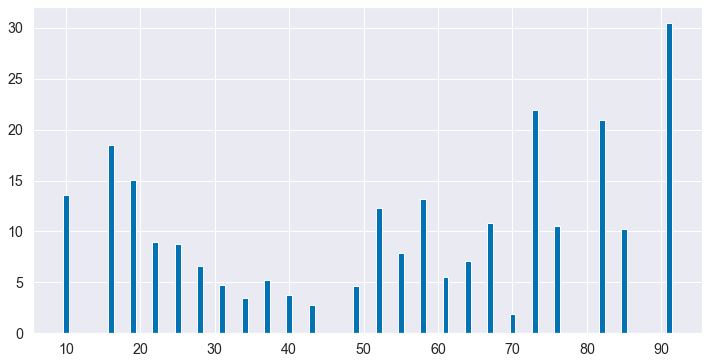

In [28]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.bar(bins[:-1], mae_per_bin);

In [94]:
def plot_true_vs_prediction_per_specie(y_true, y_pred):
    f, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    palette = sns.color_palette()
    
    x_straight = range(int(np.min(y_true)) - 1, int(np.max(y_true)) + 1)
    ax.plot(x_straight, x_straight, '--', color=palette[1], linewidth=2)
    
    ax.scatter(y_true, y_pred, color=palette[0], alpha=0.5, label='Predictions')
    
    ax.set_xlabel('Temperature °C (truth)')
    ax.set_ylabel('Temperature °C (prediction)')
    return f, ax

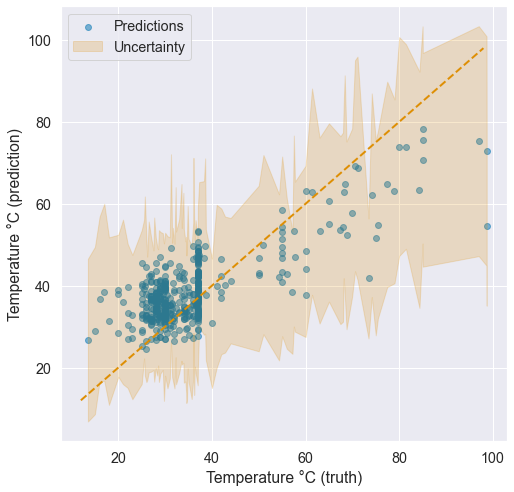

In [95]:
y_true = val_df['growth_tmp_actual'].values
y_pred = val_df['growth_tmp_prediction'].values
_, ax = plot_true_vs_prediction_per_specie(y_true, y_pred);

pred_mean = val_df[['growth_tmp_actual', 'growth_tmp_prediction']].groupby('growth_tmp_actual').mean()
std_mean = val_df[['growth_tmp_actual', 'growth_tmp_std']].groupby('growth_tmp_actual').mean().reset_index()
x_fill = std_mean['growth_tmp_actual'].values
x_base = pred_mean['growth_tmp_prediction'].values
y_fill_1 = x_base - std_mean['growth_tmp_std'].values
y_fill_2 = x_base + std_mean['growth_tmp_std'].values
ax.fill_between(x_fill, y_fill_1, y_fill_2, alpha=0.2, color=palette[1], label='Uncertainty');
ax.legend();

## Classification results

In [31]:
def discretize_temperatures(temperatures):
    temp_cats = np.zeros((len(temperatures),), dtype=np.int8)
    for i, t in enumerate(temperatures):
        if t < 20:
            temp_cats[i] = 0
        elif t >= 20 and t < 45:
            temp_cats[i] = 1
        elif t >= 45 and t < 75:
            temp_cats[i] = 2
        else:
            temp_cats[i] = 3
        
    return temp_cats

In [32]:
y_true_cat = discretize_temperatures(y_true)
y_pred_cat = discretize_temperatures(y_pred)

In [33]:
l = len(y_true_cat)
100 * np.sum([1 if y_true_cat[i] == y_pred_cat[i] else 0 for i in range(l)]) / l

87.41721854304636

In [34]:
def accuracy_per_class(y_true_cat, y_pred_cat):
    acc_per_class = {}
    for i in range(4):
        cat_ix = [ix for ix, c in enumerate(y_true_cat) if i == c]
        acc_per_class[i] = 100 * np.sum([1 if y_true_cat[ix] == y_pred_cat[ix] else 0 for ix in cat_ix]) / len(cat_ix)
    return acc_per_class

In [35]:
accuracy_per_class(y_true_cat, y_pred_cat)

{0: 0.0, 1: 91.97994987468671, 2: 72.22222222222223, 3: 23.076923076923077}

## GC content and IVYWREL content

In [42]:
common_patterns_path = os.path.join(os.getcwd(), 'data/condensed_traits/gc_content_IVYWREL_content.csv')
common_patterns_df = pd.merge(
    pd.read_csv(common_patterns_path).set_index('species_taxid'),
    val_df,
    on='species_taxid',
)
common_patterns_df.head()

,gc_content,IVYWREL_content,growth_tmp_actual,growth_tmp_prediction,growth_tmp_std
species_taxid,,,,,
7,0.674153,0.128590,30.00,36.67,15.47
14,0.338561,0.141845,74.15,62.08,24.86
24,0.448970,0.126567,27.00,27.02,19.60
35,0.707531,0.130083,27.00,40.85,15.06
63,0.637449,0.131033,30.00,35.35,16.61


In [90]:
def compute_and_plot_pattern_against_ogt(y_actual, pattern_data, pattern_type):
    palette = sns.color_palette()
    
    X_bins = sm.add_constant(pattern_data[:,np.newaxis])
    model = sm.OLS(y_actual, X_bins)

    results = model.fit()
    
    std, upper, lower = wls_prediction_std(results)

    a = results.params[1]
    b = results.params[0]
    y_fit = a * pattern_data + b
    
    f, ax = plot_true_vs_prediction_per_specie(y_actual, y_fit)
    
    df_data = [
        [y_actual[i], y_fit[i], std[i]]
        for i in range(len(y_actual))
    ]
    df = pd.DataFrame(df_data, columns=['growth_tmp_actual', 'growth_tmp_prediction', 'growth_tmp_std'])
    
    pred_mean = df[['growth_tmp_actual', 'growth_tmp_prediction']].groupby('growth_tmp_actual').mean()
    std_mean = df[['growth_tmp_actual', 'growth_tmp_std']].groupby('growth_tmp_actual').mean().reset_index()
    x_fill = std_mean['growth_tmp_actual'].values
    x_base = pred_mean['growth_tmp_prediction'].values
    y_fill_1 = x_base - std_mean['growth_tmp_std'].values
    y_fill_2 = x_base + std_mean['growth_tmp_std'].values
    ax.fill_between(x_fill, y_fill_1, y_fill_2, alpha=0.2, color=palette[1], label='Uncertainty');
    
    ax.set_title(f'{pattern_type} model')
    ax.legend()
    
    return a, b, y_fit, p_value

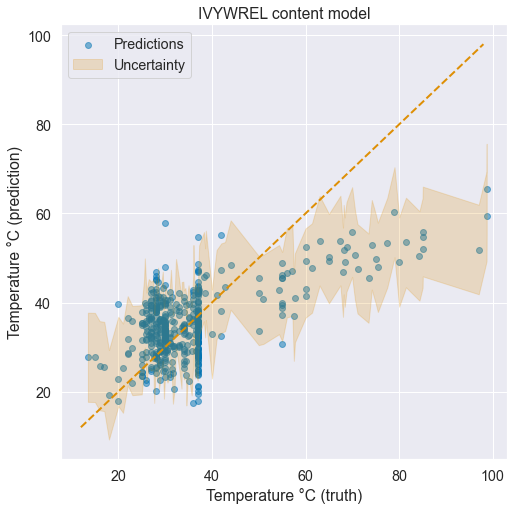

In [91]:
compute_and_plot_pattern_against_ogt(
    y_actual=common_patterns_df['growth_tmp_actual'].values, 
    pattern_data=common_patterns_df['IVYWREL_content'].values, 
    pattern_type='IVYWREL content',
);